In [10]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime

from scipy.stats import norm
from scipy.optimize import minimize

# Import matplotlib for visualization
import matplotlib
import matplotlib.pyplot as plt

# Plot settings
import warnings
warnings.filterwarnings('ignore')

sp500_df = yf.download('SPY', start='2020-01-01', end=datetime.today().strftime('%Y-%m-%d'))

print(sp500_df)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-12-31  320.529999  322.130005  320.149994  321.859985  308.234436   
2020-01-02  323.540009  324.890015  322.529999  324.869995  311.117004   
2020-01-03  321.160004  323.640015  321.100006  322.410004  308.761139   
2020-01-06  320.489990  323.730011  320.359985  323.640015  309.939117   
2020-01-07  323.019989  323.540009  322.239990  322.730011  309.067627   
...                ...         ...         ...         ...         ...   
2022-11-07  377.709991  380.570007  375.529999  379.950012  379.950012   
2022-11-08  381.109985  385.119995  377.720001  382.000000  382.000000   
2022-11-09  379.929993  381.140015  373.609985  374.130005  374.130005   
2022-11-10  388.049988  395.040009  385.640015  394.690002  394.690002   
2022-11-11  395.589996  399.350006  393.609

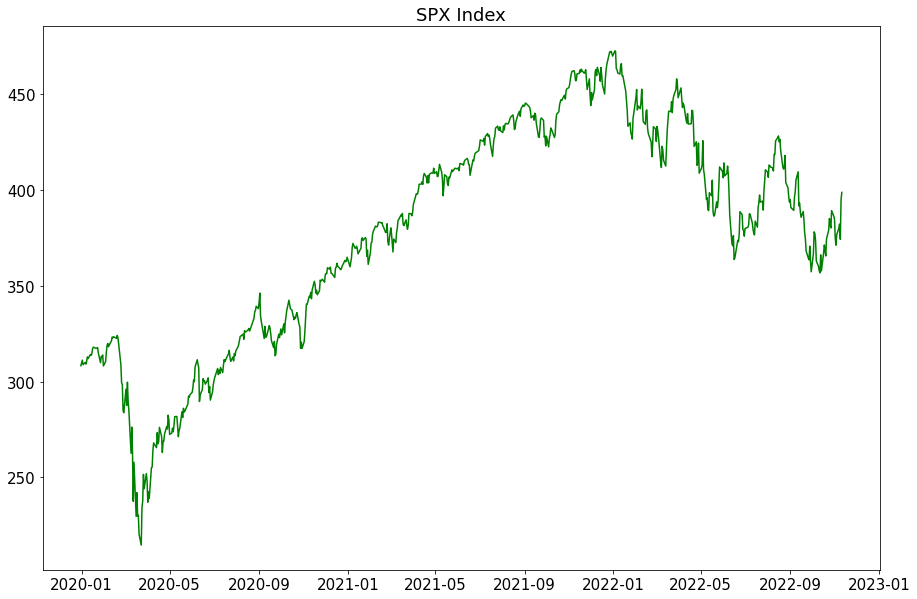

In [17]:
matplotlib.rcParams['figure.figsize']= [15, 10]
matplotlib.rcParams['font.size'] = 15
plt.plot(sp500_df['Adj Close'], color='green')
plt.title('SPX Index');

In [18]:
returns = np.log(sp500_df['Adj Close']).diff().fillna(0)

In [5]:
returns

Date
2019-12-31    0.000000
2020-01-02    0.009308
2020-01-03   -0.007601
2020-01-06    0.003808
2020-01-07   -0.002816
                ...   
2022-11-07    0.009520
2022-11-08    0.005381
2022-11-09   -0.020817
2022-11-10    0.053497
2022-11-11    0.009632
Name: Adj Close, Length: 724, dtype: float64

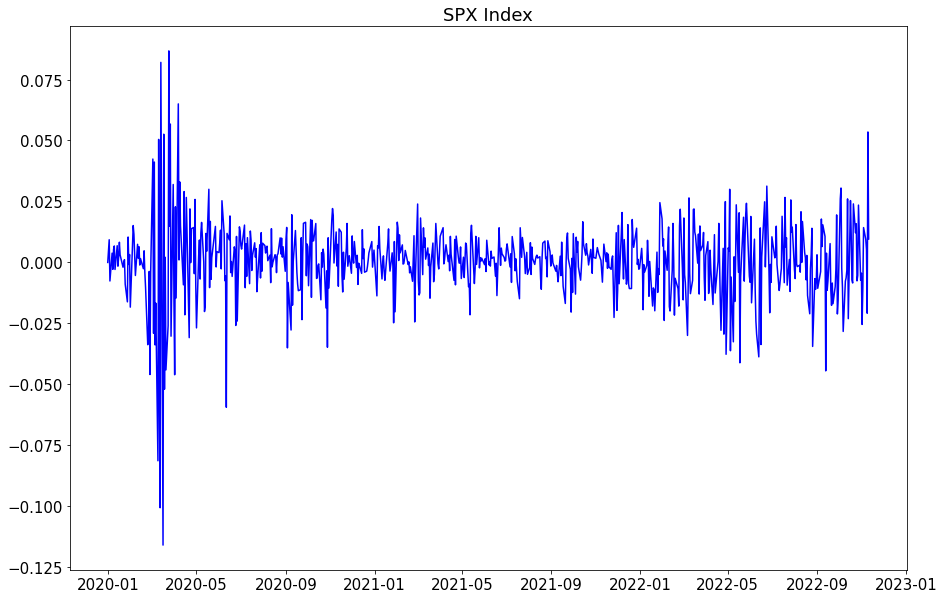

In [19]:
plt.plot(returns, color='blue')
plt.title('SPX Index');

In [20]:
# GARCH(1,1) function
def garch(omega, alpha, beta, ret):
    
    var = []
    for i in range(len(ret)):
        if i==0:
            var.append(omega/np.abs(1-alpha-beta))
        else:
            var.append(omega + alpha * ret[i-1]**2 + beta * var[i-1])
            
    return np.array(var)

In [21]:
garch(np.var(returns),0.1,0.8,returns) [:3]

array([0.00254714, 0.00229243, 0.00209732])

In [22]:
# Log likelihood function
def likelihood(params, ret):
    
    omega= params[0]; alpha = params[1]; beta = params[2]
    
    variance = garch(omega, alpha, beta, ret) # GARCH(1,1) function

    llh = []
    for i in range(len(ret)):
        llh.append(np.log(norm.pdf(ret[i], 0, np.sqrt(variance[i]))))
    
    return -np.sum(np.array(llh))

In [23]:
likelihood((np.var(returns), 0.1, 0.8), returns)

-1662.125258445523

In [24]:
# Specify optimization input
param = ['omega', 'alpha', 'beta']
initial_values = ((np.var(returns), 0.1, 0.8))

In [25]:
res = minimize(likelihood, initial_values, args = returns,  method='Nelder-Mead', options={'disp':False})
res

 final_simplex: (array([[7.37171216e-06, 1.95262345e-01, 7.69080900e-01],
       [7.37455508e-06, 1.95323043e-01, 7.69015570e-01],
       [7.37157346e-06, 1.95301789e-01, 7.69057268e-01],
       [7.37543652e-06, 1.95270837e-01, 7.69059913e-01]]), array([-2163.89616622, -2163.89616566, -2163.89616557, -2163.89616543]))
           fun: -2163.8961662238135
       message: 'Optimization terminated successfully.'
          nfev: 199
           nit: 110
        status: 0
       success: True
             x: array([7.37171216e-06, 1.95262345e-01, 7.69080900e-01])

In [26]:
# GARCH parameters
dict(zip(param,np.around(res['x']*100,4)))

{'omega': 0.0007, 'alpha': 19.5262, 'beta': 76.9081}

In [27]:
# Parameters
omega = res['x'][0]; alpha = res['x'][1]; beta = res['x'][2]

# Variance
var = garch(omega,alpha,beta,returns)

# Annualised conditional volatility
ann_vol = np.sqrt(var*252) * 100
ann_vol[0:10]

array([22.82514519, 20.47579205, 19.58712511, 18.49509289, 16.99382355,
       15.6390844 , 14.85200714, 14.51529746, 13.59060302, 13.55519767])

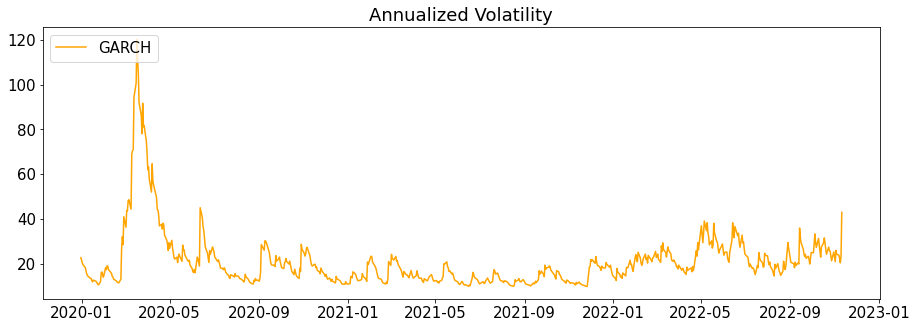

In [28]:
# Visualise GARCH volatility
matplotlib.rcParams['figure.figsize']= [15,5]
plt.title('Annualized Volatility')
plt.plot(returns.index, ann_vol, color='orange', label='GARCH')
plt.legend(loc=2);

In [29]:
# ARCH library

from arch import arch_model

g1 = arch_model(returns, vol='GARCH', mean='Zero', p=1, o=0, q=1, dist='normal')

model = g1.fit()



Iteration:      1,   Func. Count:      4,   Neg. LLF: -2162.5520122624594
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2162.552010529311
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


In [30]:
# Model output
print(model)

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                2162.55
Distribution:                  Normal   AIC:                          -4319.10
Method:            Maximum Likelihood   BIC:                          -4305.35
                                        No. Observations:                  724
Date:                Sun, Nov 13 2022   Df Residuals:                      724
Time:                        12:17:59   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      5.0968e-06  6.767e-10   7531.557      0.000 [5.

In [31]:
model.params

omega       0.000005
alpha[1]    0.200000
beta[1]     0.780000
Name: params, dtype: float64

In [32]:
dict(zip(param,np.around(res['x']*100,4)))

{'omega': 0.0007, 'alpha': 19.5262, 'beta': 76.9081}

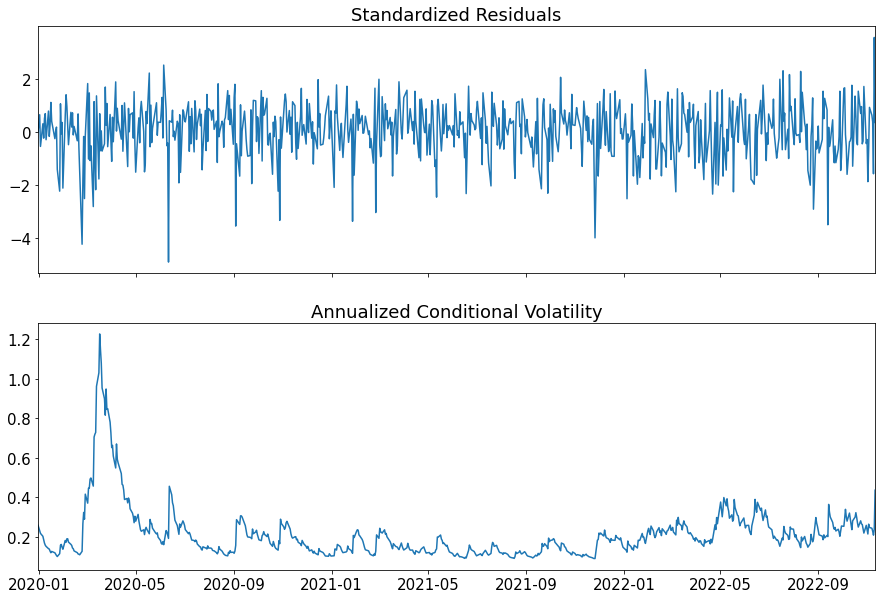

In [33]:
matplotlib.rcParams['figure.figsize']= [15,10]
fig=model.plot(annualize='D')